#Thêm thư viện và các package cần thiết

In [ ]:
! pip -q install torchtext==0.6.0
! pip -q install pyvi

import nltk
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 36.8 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import os
import math
from torchtext import data

##Tải tập dữ liệu

In [ ]:
os.makedirs('./data/', exist_ok=True)
! gdown --id 1qM5B1lDoRh7aB2zvigzZzWXP6djHL1I7

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qM5B1lDoRh7aB2zvigzZzWXP6djHL1I7
To: /content/en_vi.zip
100% 10.1M/10.1M [00:00<00:00, 52.4MB/s]


In [ ]:
! unzip -o en_vi.zip

Archive:  en_vi.zip
  inflating: data/tst2013.en         
  inflating: data/tst2012.vi         
  inflating: data/train.en           
  inflating: data/tst2013.vi         
  inflating: data/train.vi           
  inflating: data/tst2012.en         


#Xây dựng mô hình

##Embedder


In [ ]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model

        self.embed = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embed(x)

##Position Encoder

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_length=200, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_seq_length, d_model)

        # Bảng pe mình vẽ ở trên
        for pos in range(max_seq_length):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):

        x = x*math.sqrt(self.d_model)
        seq_length = x.size(1)

        pe = Variable(self.pe[:, :seq_length], requires_grad=False)

        if x.is_cuda:
            pe.cuda()
        # cộng embedding vector với pe
        x = x + pe
        x = self.dropout(x)

        return x
# PositionalEncoder(256)(torch.rand(5, 30, 256)).shape

##Attention

In [ ]:
def attention(q, k, v, mask=None, dropout=None):
    """
    q: batch_size x head x seq_length x d_model
    k: batch_size x head x seq_length x d_model
    v: batch_size x head x seq_length x d_model
    mask: batch_size x 1 x 1 x seq_length
    output: batch_size x head x seq_length x d_model
    """

    # attention score được tính bằng cách nhân q với k
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask==0, -1e9)
    # xong rồi thì chuẩn hóa bằng softmax
    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output, scores

# attention(torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512))

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        assert d_model % heads == 0

        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.attn = None

        # tạo ra 3 ma trận trọng số là q_linear, k_linear, v_linear như hình trên
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        q: batch_size x seq_length x d_model
        k: batch_size x seq_length x d_model
        v: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        bs = q.size(0)
        # nhân ma trận trọng số q_linear, k_linear, v_linear với dữ liệu đầu vào q, k, v
        # ở bước encode các bạn lưu ý rằng q, k, v chỉ là một (xem hình trên)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # tính attention score
        scores, self.attn = attention(q, k, v, mask, self.dropout)

        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        output = self.out(concat)
        return output

# MultiHeadAttention(8, 512)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 30, 512)).shape

##Norm layer


In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model

        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()

        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

##Encoder layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        x: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """


        x2 = self.norm_1(x)
        # tính attention value, các bạn để ý q, k, v là giống nhau
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# EncoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32 , 1, 30)).shape

##Decoder layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        """
        x: batch_size x seq_length x d_model
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        """
        # Các bạn xem hình trên, kiến trúc mình vẽ với code ở chỗ này tương đương nhau.
        x2 = self.norm_1(x)
        # multihead attention thứ nhất, chú ý các từ ở target
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        # masked mulithead attention thứ 2. k, v là giá trị output của mô hình encoder
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

# DecoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

##Encoder

In [ ]:
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, src, mask):
        """
        src: batch_size x seq_length
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

# Encoder(232, 512,6,8,0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 1, 30)).shape

##Decoder

In [ ]:
class Decoder(nn.Module):
    """Một decoder có nhiều decoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        """
        trg: batch_size x seq_length
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

# Decoder(232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

#Transformer và các hàm cần thiết


In [ ]:
class Transformer(nn.Module):
    """ Cuối cùng ghép chúng lại với nhau để được mô hình transformer hoàn chỉnh
    """
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        """
        src: batch_size x seq_length
        trg: batch_size x seq_length
        src_mask: batch_size x 1 x seq_length
        trg_mask batch_size x 1 x seq_length
        output: batch_size x seq_length x vocab_size
        """
        e_outputs = self.encoder(src, src_mask)

        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

# Transformer(232, 232, 512, 6, 8, 0.1)

In [ ]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)

        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [ ]:

def nopeak_mask(size, device):
    """Tạo mask được sử dụng trong decoder để lúc dự đoán trong quá trình huấn luyện
     mô hình không nhìn thấy được các từ ở tương lai
    """
    np_mask = np.triu(np.ones((1, size, size)),
    k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0)
    np_mask = np_mask.to(device)

    return np_mask

def create_masks(src, trg, src_pad, trg_pad, device):
    """ Tạo mask cho encoder,
    để mô hình không bỏ qua thông tin của các kí tự PAD do chúng ta thêm vào
    """
    src_mask = (src != src_pad).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != trg_pad).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size, device)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask

    else:
        trg_mask = None
    return src_mask, trg_mask

In [ ]:
from nltk.corpus import wordnet
import re

def get_synonym(word, SRC):
    syns = wordnet.synsets(word)
    for s in syns:
        for l in s.lemmas():
            if SRC.vocab.stoi[l.name()] != 0:
                return SRC.vocab.stoi[l.name()]

    return 0

def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

In [ ]:
def init_vars(src, model, SRC, TRG, device, k, max_len):
    """ Tính toán các ma trận cần thiết trong quá trình translation sau khi mô hình học xong
    """
    init_tok = TRG.vocab.stoi['<sos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)

    # tính sẵn output của encoder
    e_output = model.encoder(src, src_mask)

    outputs = torch.LongTensor([[init_tok]])

    outputs = outputs.to(device)

    trg_mask = nopeak_mask(1, device)
    # dự đoán kí tự đầu tiên
    out = model.out(model.decoder(outputs,
    e_output, src_mask, trg_mask))
    out = F.softmax(out, dim=-1)

    probs, ix = out[:, -1].data.topk(k)
    log_scores = torch.Tensor([math.log(prob) for prob in probs.data[0]]).unsqueeze(0)

    outputs = torch.zeros(k, max_len).long()
    outputs = outputs.to(device)
    outputs[:, 0] = init_tok
    outputs[:, 1] = ix[0]

    e_outputs = torch.zeros(k, e_output.size(-2),e_output.size(-1))

    e_outputs = e_outputs.to(device)
    e_outputs[:, :] = e_output[0]

    return outputs, e_outputs, log_scores

def k_best_outputs(outputs, out, log_scores, i, k):

    probs, ix = out[:, -1].data.topk(k)
    log_probs = torch.Tensor([math.log(p) for p in probs.data.view(-1)]).view(k, -1) + log_scores.transpose(0,1)
    k_probs, k_ix = log_probs.view(-1).topk(k)

    row = k_ix // k
    col = k_ix % k

    outputs[:, :i] = outputs[row, :i]
    outputs[:, i] = ix[row, col]

    log_scores = k_probs.unsqueeze(0)

    return outputs, log_scores

def beam_search(src, model, SRC, TRG, device, k, max_len):

    outputs, e_outputs, log_scores = init_vars(src, model, SRC, TRG, device, k, max_len)
    eos_tok = TRG.vocab.stoi['<eos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)
    ind = None
    for i in range(2, max_len):

        trg_mask = nopeak_mask(i, device)

        out = model.out(model.decoder(outputs[:,:i],
        e_outputs, src_mask, trg_mask))

        out = F.softmax(out, dim=-1)

        outputs, log_scores = k_best_outputs(outputs, out, log_scores, i, k)

        ones = (outputs==eos_tok).nonzero() # Occurrences of end symbols for all input sentences.
        sentence_lengths = torch.zeros(len(outputs), dtype=torch.long).cuda()
        for vec in ones:
            i = vec[0]
            if sentence_lengths[i]==0: # First end symbol has not been found yet
                sentence_lengths[i] = vec[1] # Position of first end symbol

        num_finished_sentences = len([s for s in sentence_lengths if s > 0])

        if num_finished_sentences == k:
            alpha = 0.7
            div = 1/(sentence_lengths.type_as(log_scores)**alpha)
            _, ind = torch.max(log_scores * div, 1)
            ind = ind.data[0]
            break

    if ind is None:

        length = (outputs[0]==eos_tok).nonzero()[0] if len((outputs[0]==eos_tok).nonzero()) > 0 else -1
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[0][1:length]])

    else:
        length = (outputs[ind]==eos_tok).nonzero()[0]
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[ind][1:length]])

In [ ]:
def translate_sentence(sentence, model, SRC, TRG, device, k, max_len):
    """Dịch một câu sử dụng beamsearch
    """
    model.eval()
    indexed = []
    sentence = SRC.preprocess(sentence)

    for tok in sentence:
        if SRC.vocab.stoi[tok] != SRC.vocab.stoi['<eos>']:
            indexed.append(SRC.vocab.stoi[tok])
        else:
            indexed.append(get_synonym(tok, SRC))

    sentence = Variable(torch.LongTensor([indexed]))

    sentence = sentence.to(device)

    sentence = beam_search(sentence, model, SRC, TRG, device, k, max_len)

    return  multiple_replace({' ?' : '?',' !':'!',' .':'.','\' ':'\'',' ,':','}, sentence)

###Optimizer


In [ ]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, init_lr, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def state_dict(self):
        optimizer_state_dict = {
            'init_lr':self.init_lr,
            'd_model':self.d_model,
            'n_warmup_steps':self.n_warmup_steps,
            'n_steps':self.n_steps,
            '_optimizer':self._optimizer.state_dict(),
        }

        return optimizer_state_dict

    def load_state_dict(self, state_dict):
        self.init_lr = state_dict['init_lr']
        self.d_model = state_dict['d_model']
        self.n_warmup_steps = state_dict['n_warmup_steps']
        self.n_steps = state_dict['n_steps']

        self._optimizer.load_state_dict(state_dict['_optimizer'])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [ ]:
from torchtext.data.metrics import bleu_score

def bleu(valid_src_data, valid_trg_data, model, SRC, TRG, device, k, max_strlen):
    pred_sents = []
    for sentence in valid_src_data:
        pred_trg = translate_sentence(sentence, model, SRC, TRG, device, k, max_strlen)
        pred_sents.append(pred_trg)

    pred_sents = [TRG.preprocess(sent) for sent in pred_sents]
    trg_sents = [[sent.split()] for sent in valid_trg_data]

    return bleu_score(pred_sents, trg_sents)

##Dataloader cho dịch Anh-Việt

###Tokenize

In [ ]:
import spacy
import re
from pyvi import ViTokenizer

class tokenize_vi(object):

    def __init__(self, text):
        self.vi = ViTokenizer.tokenize
    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok for tok in self.vi(sentence).split() if tok != " "]

class tokenize_en(object):

    def __init__(self, lang):
        self.en = spacy.load(lang)
    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok.text for tok in self.en.tokenizer(sentence) if tok.text != " "]

In [ ]:
import os
import pickle
import pandas as pd
from pyvi import ViTokenizer
def read_data(src_file, trg_file):
    src_data = open(src_file, encoding='utf-8').read().strip().split('\n')

    trg_data = open(trg_file, encoding='utf-8').read().strip().split('\n')

    return src_data, trg_data

def create_fields(src_lang, trg_lang):

    t_src = tokenize_en(src_lang)
    t_trg = tokenize_vi(trg_lang)

    TRG = data.Field(lower=True, tokenize=t_trg.tokenizer, init_token='<sos>', eos_token='<eos>')
    SRC = data.Field(lower=True, tokenize=t_src.tokenizer)

    return SRC, TRG

def create_dataset(src_data, trg_data, max_strlen, batchsize, device, SRC, TRG, istrain=True):

    print("creating dataset and iterator... ")

    raw_data = {'src' : [line for line in src_data], 'trg': [line for line in trg_data]}
    df = pd.DataFrame(raw_data, columns=["src", "trg"])

    mask = (df['src'].str.count(' ') < max_strlen) & (df['trg'].str.count(' ') < max_strlen)
    df = df.loc[mask]

    df.to_csv("translate_transformer_temp.csv", index=False)

    data_fields = [('src', SRC), ('trg', TRG)]
    train = data.TabularDataset('./translate_transformer_temp.csv', format='csv', fields=data_fields)

    train_iter = MyIterator(train, batch_size=batchsize, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=istrain, shuffle=True)

    os.remove('translate_transformer_temp.csv')

    if istrain:
        SRC.build_vocab(train)
        TRG.build_vocab(train)

    return train_iter

In [ ]:
opt = {
    'train_src_data':'./data/train.en',
    'train_trg_data':'./data/train.vi',
    'valid_src_data':'./data/tst2013.en',
    'valid_trg_data':'./data/tst2013.vi',
    'src_lang':'en_core_web_sm',
    'trg_lang':'vitokenize',
    'max_strlen':160,
    'batchsize':1500,
    'device':'cuda',
    'd_model': 512,
    'n_layers': 6,
    'heads': 8,
    'dropout': 0.1,
    'lr':0.0001,
    'epochs':5,
    'printevery': 200,
    'k':5,
}

In [ ]:
train_src_data, train_trg_data = read_data(opt['train_src_data'], opt['train_trg_data'])
valid_src_data, valid_trg_data = read_data(opt['valid_src_data'], opt['valid_trg_data'])

SRC, TRG = create_fields(opt['src_lang'], opt['trg_lang'])
train_iter = create_dataset(train_src_data, train_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=True)
valid_iter = create_dataset(valid_src_data, valid_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'], SRC, TRG, istrain=False)

creating dataset and iterator... 
creating dataset and iterator... 


###Khởi tạo mô hình

In [ ]:
model = Transformer(len(SRC.vocab), len(TRG.vocab), opt['d_model'], opt['n_layers'], opt['heads'], opt['dropout'])

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
model = model.to(opt['device'])

In [ ]:
sum(p.numel() for p in model.parameters())

100577320

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP_Data/model_checkpoint_en-vi_ep20.pt'))

<All keys matched successfully>

In [ ]:
sentence='My family was not poor , and myself , I had never experienced hunger'
trans_sent = translate_sentence(sentence, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
trans_sent = trans_sent.replace("_"," ")
trans_sent

'gia đình tôi không nghèo, và bản thân tôi, tôi chưa bao giờ trải qua nạn đói.'

##Visualize

In [ ]:
import seaborn
import matplotlib.pyplot as plt

def draw(data, x, y, ax):
    seaborn.heatmap(data,
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0,
                    cbar=False, ax=ax, annot=False)

Encoder Layer 2


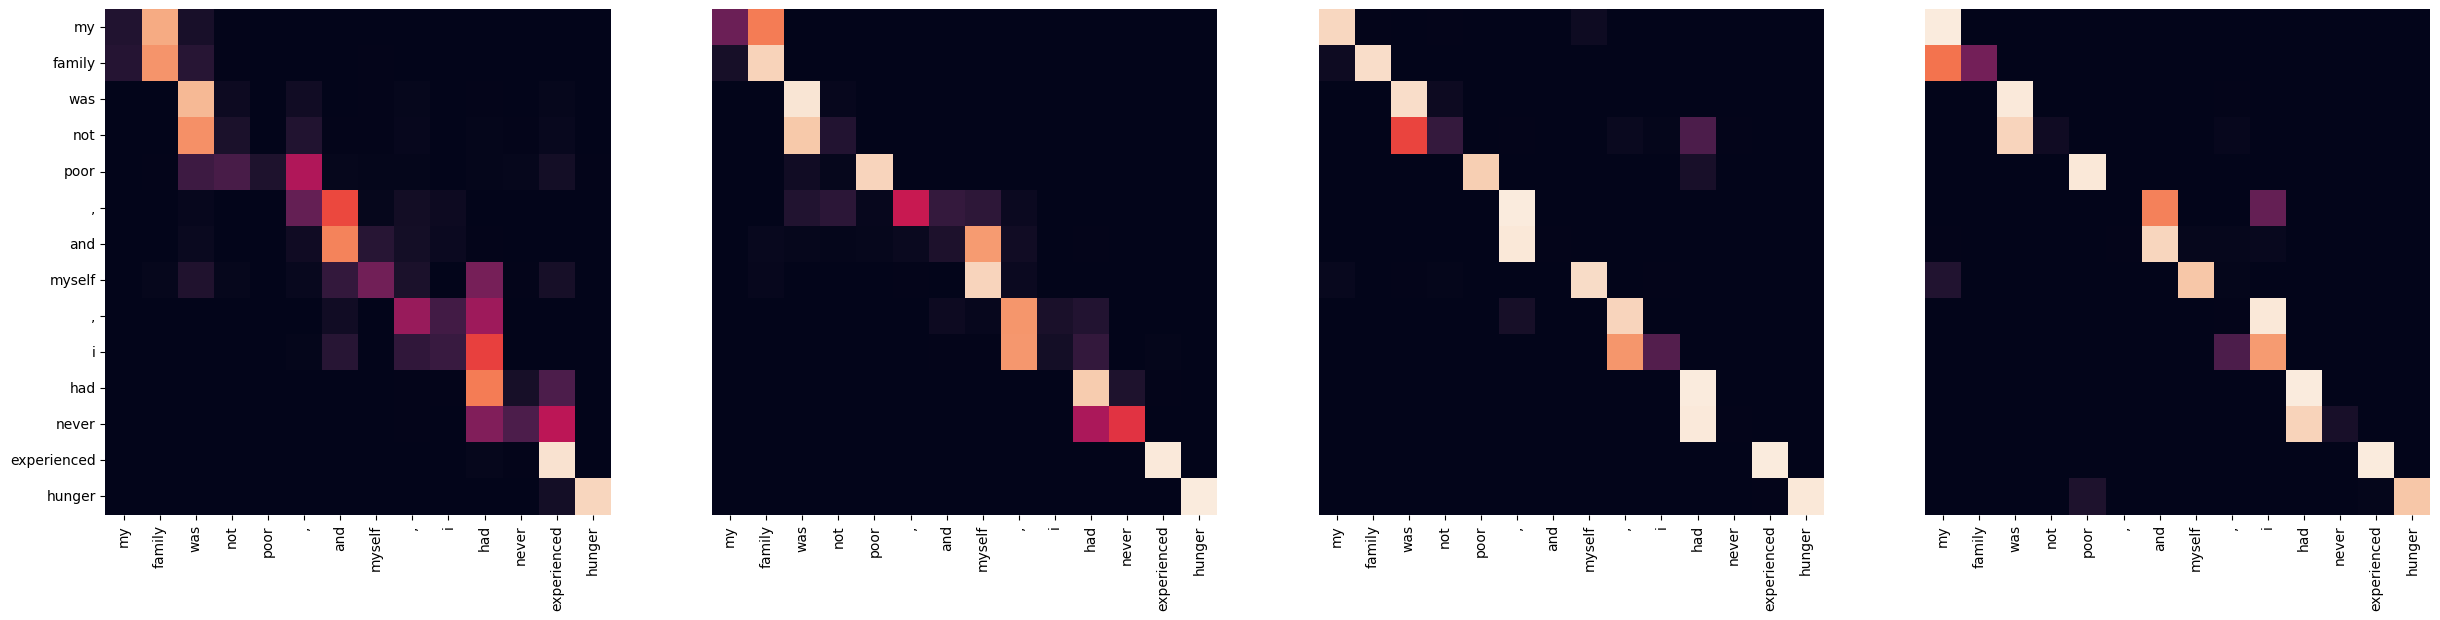

Encoder Layer 4


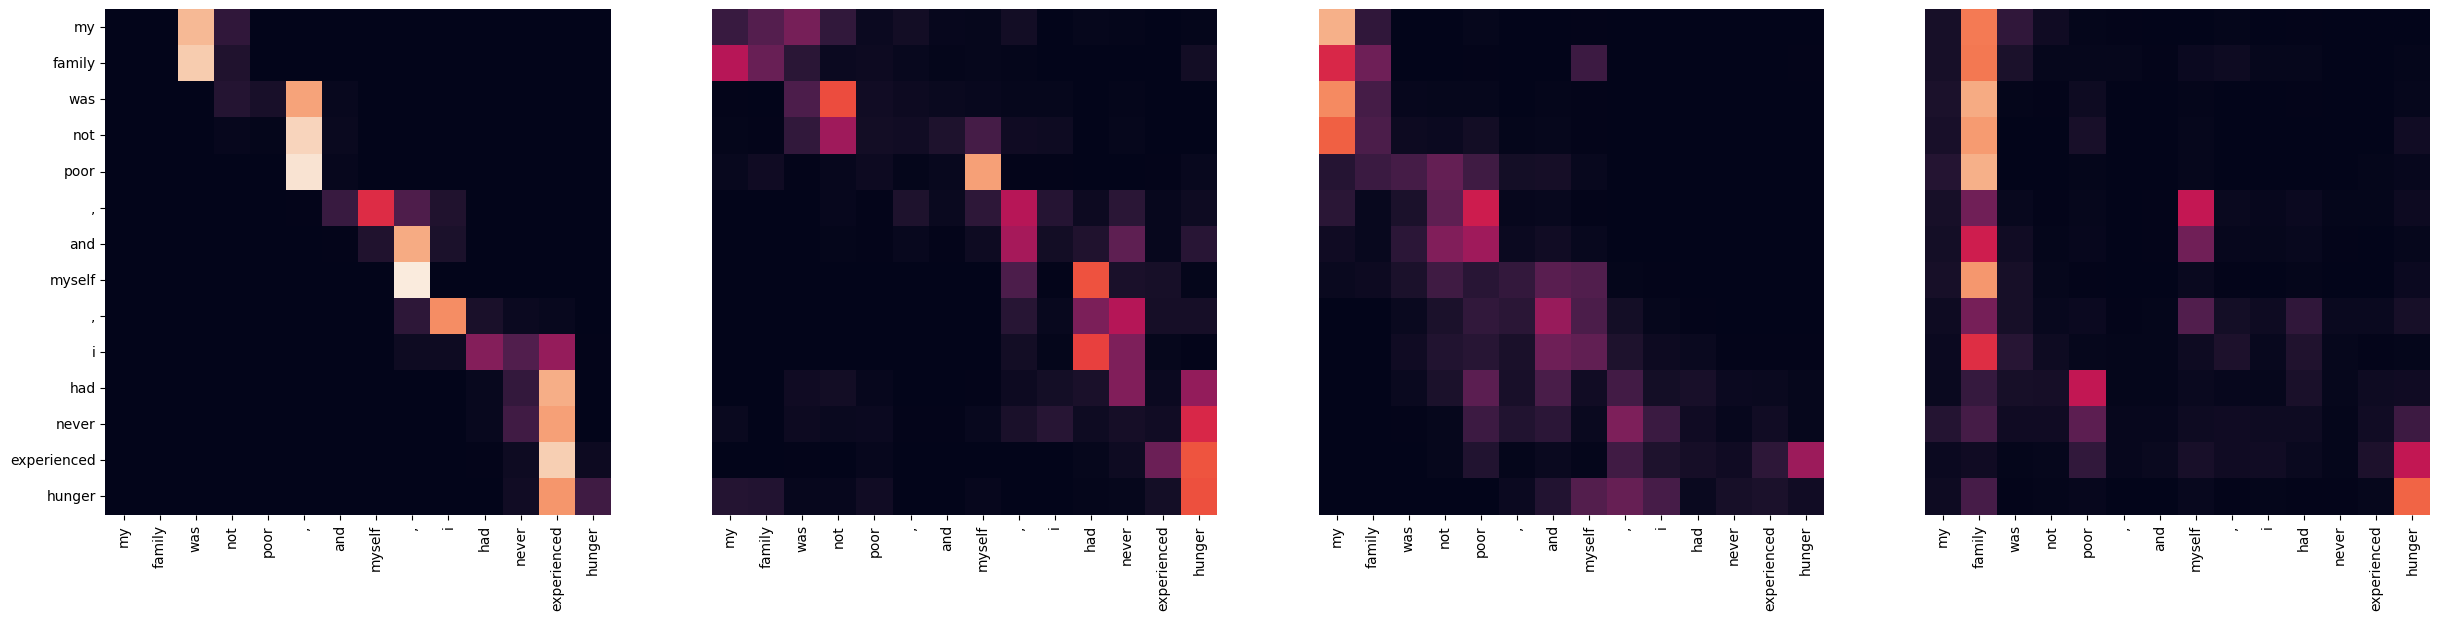

Encoder Layer 6


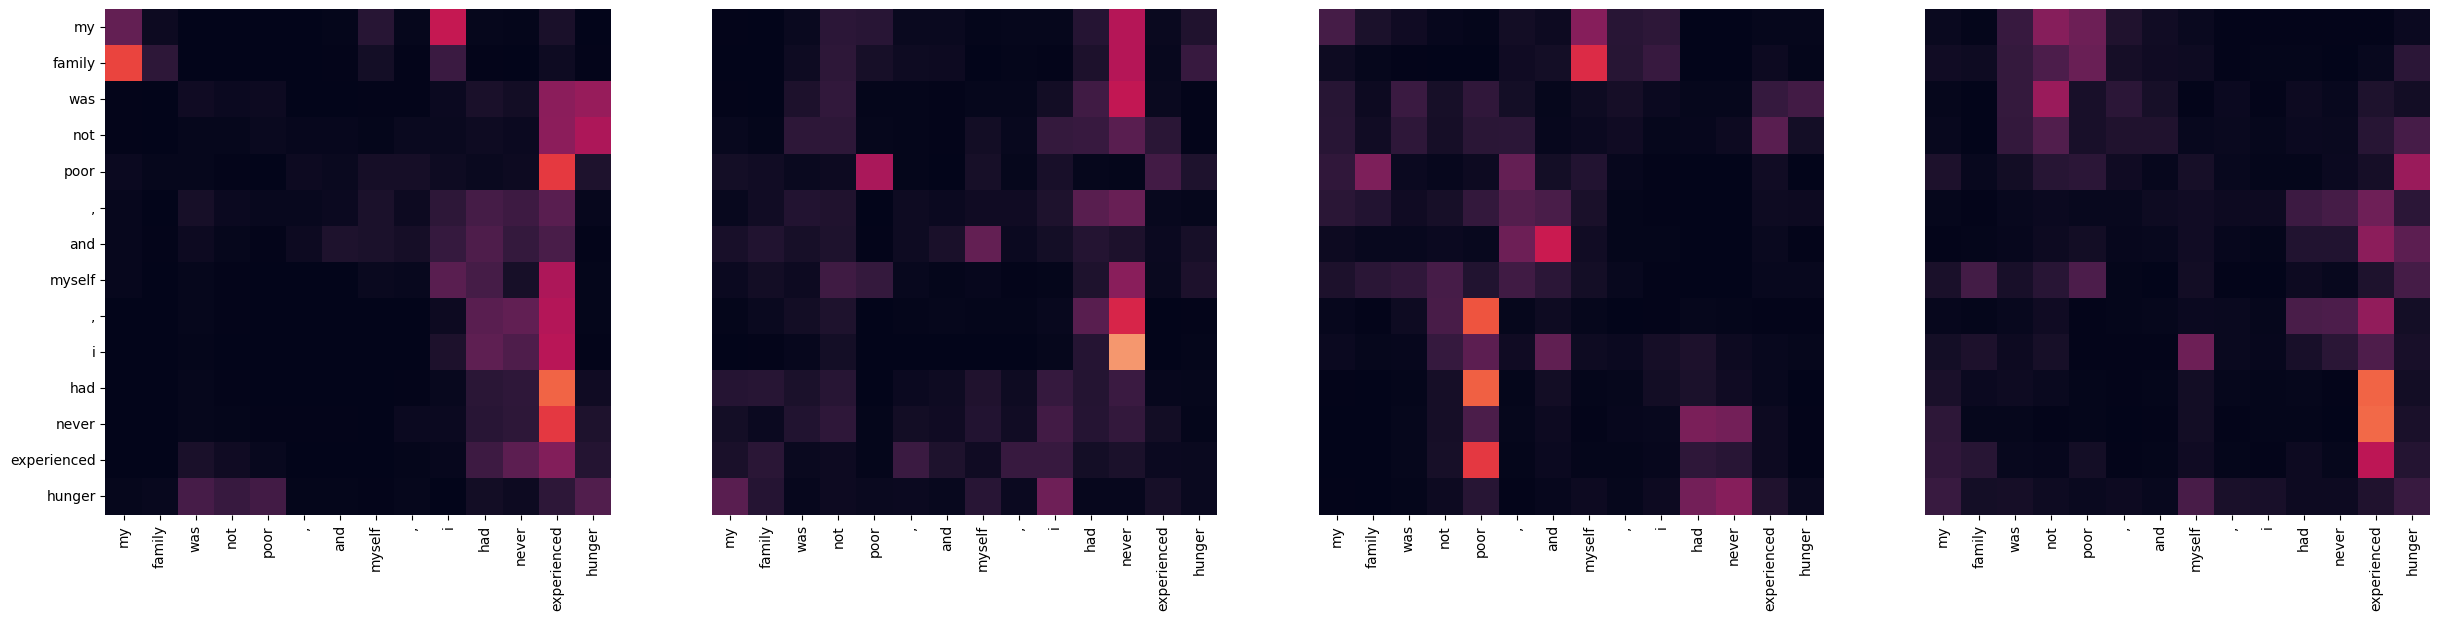

In [ ]:
sent = SRC.preprocess(sentence)

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(30, 15))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].attn.attn[0, h].data.cpu(),
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()

##Dataloader cho dịch Việt-Anh

In [ ]:
import spacy
import re
from pyvi import ViTokenizer

class tokenize_vi(object):

    def __init__(self):
        self.vi = ViTokenizer.tokenize
    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok for tok in self.vi(sentence).split() if tok != " "]

class tokenize_en(object):

    def __init__(self, lang):
        self.en = spacy.load(lang)
    def tokenizer(self, sentence):
        sentence = re.sub(
        r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
        sentence = re.sub(r"[ ]+", " ", sentence)
        sentence = re.sub(r"\!+", "!", sentence)
        sentence = re.sub(r"\,+", ",", sentence)
        sentence = re.sub(r"\?+", "?", sentence)
        sentence = sentence.lower()
        return [tok.text for tok in self.en.tokenizer(sentence) if tok.text != " "]

In [ ]:
import os
import pickle
import pandas as pd
from pyvi import ViTokenizer
def read_data(src_file, trg_file):
    src_data = open(src_file, encoding='utf-8').read().strip().split('\n')

    trg_data = open(trg_file, encoding='utf-8').read().strip().split('\n')

    return src_data, trg_data

def create_fields(_, trg_lang):

    t_src = tokenize_vi()
    t_trg = tokenize_en(trg_lang)

    TRG = data.Field(lower=True, tokenize=t_trg.tokenizer, init_token='<sos>', eos_token='<eos>')
    SRC = data.Field(lower=True, tokenize=t_src.tokenizer)

    return SRC, TRG

def create_dataset(src_data, trg_data, max_strlen, batchsize, device, SRC, TRG, istrain=True):

    print("creating dataset and iterator... ")

    raw_data = {'src' : [line for line in src_data], 'trg': [line for line in trg_data]}
    df = pd.DataFrame(raw_data, columns=["src", "trg"])

    mask = (df['src'].str.count(' ') < max_strlen) & (df['trg'].str.count(' ') < max_strlen)
    df = df.loc[mask]

    df.to_csv("translate_transformer_temp.csv", index=False)

    data_fields = [('src', SRC), ('trg', TRG)]
    train = data.TabularDataset('./translate_transformer_temp.csv', format='csv', fields=data_fields)

    train_iter = MyIterator(train, batch_size=batchsize, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=istrain, shuffle=True)

    os.remove('translate_transformer_temp.csv')

    if istrain:
        SRC.build_vocab(train)
        TRG.build_vocab(train)

    return train_iter


In [ ]:
opt = {
    'train_src_data':'./data/train.vi',
    'train_trg_data':'./data/train.en',
    'valid_src_data':'./data/tst2013.vi',
    'valid_trg_data':'./data/tst2013.en',
    'src_lang':'vitokenizer',
    'trg_lang':'en_core_web_sm',
    'max_strlen':160,
    'batchsize':1500,
    'device':'cuda',
    'd_model': 512,
    'n_layers': 6,
    'heads': 8,
    'dropout': 0.1,
    'lr':0.0001,
    'epochs':5,
    'printevery': 200,
    'k':5,
}

In [ ]:
train_src_data, train_trg_data = read_data(opt['train_src_data'], opt['train_trg_data'])
valid_src_data, valid_trg_data = read_data(opt['valid_src_data'], opt['valid_trg_data'])

SRC1, TRG1 = create_fields(opt['src_lang'], opt['trg_lang'])
train_iter = create_dataset(train_src_data, train_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'],  SRC1,TRG1, istrain=True)
valid_iter = create_dataset(valid_src_data, valid_trg_data, opt['max_strlen'], opt['batchsize'], opt['device'],  SRC1,TRG1, istrain=False)

creating dataset and iterator... 
creating dataset and iterator... 


In [ ]:
src_pad = SRC1.vocab.stoi['<pad>']
trg_pad = TRG1.vocab.stoi['<pad>']

In [ ]:
model1 = Transformer( len(SRC1.vocab),len(TRG1.vocab), opt['d_model'], opt['n_layers'], opt['heads'], opt['dropout'])

for p in model1.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model1 = model1.to(opt['device'])

In [ ]:
sum(p.numel() for p in model1.parameters())

105024516

In [ ]:
model1.load_state_dict(torch.load('/content/drive/MyDrive/NLP_Data/model_checkpoint_vi-en_20.pt'))

<All keys matched successfully>

In [ ]:
sent = "gia đình tôi không nghèo, và bản thân tôi, tôi chưa bao giờ trải qua nạn đói"
translate_sentence(sentence, model1, SRC1, TRG1, opt['device'], opt['k'], opt['max_strlen'])

'my family & apos s not poor, and it & apos s all right.'

##Visualize

Encoder Layer 2


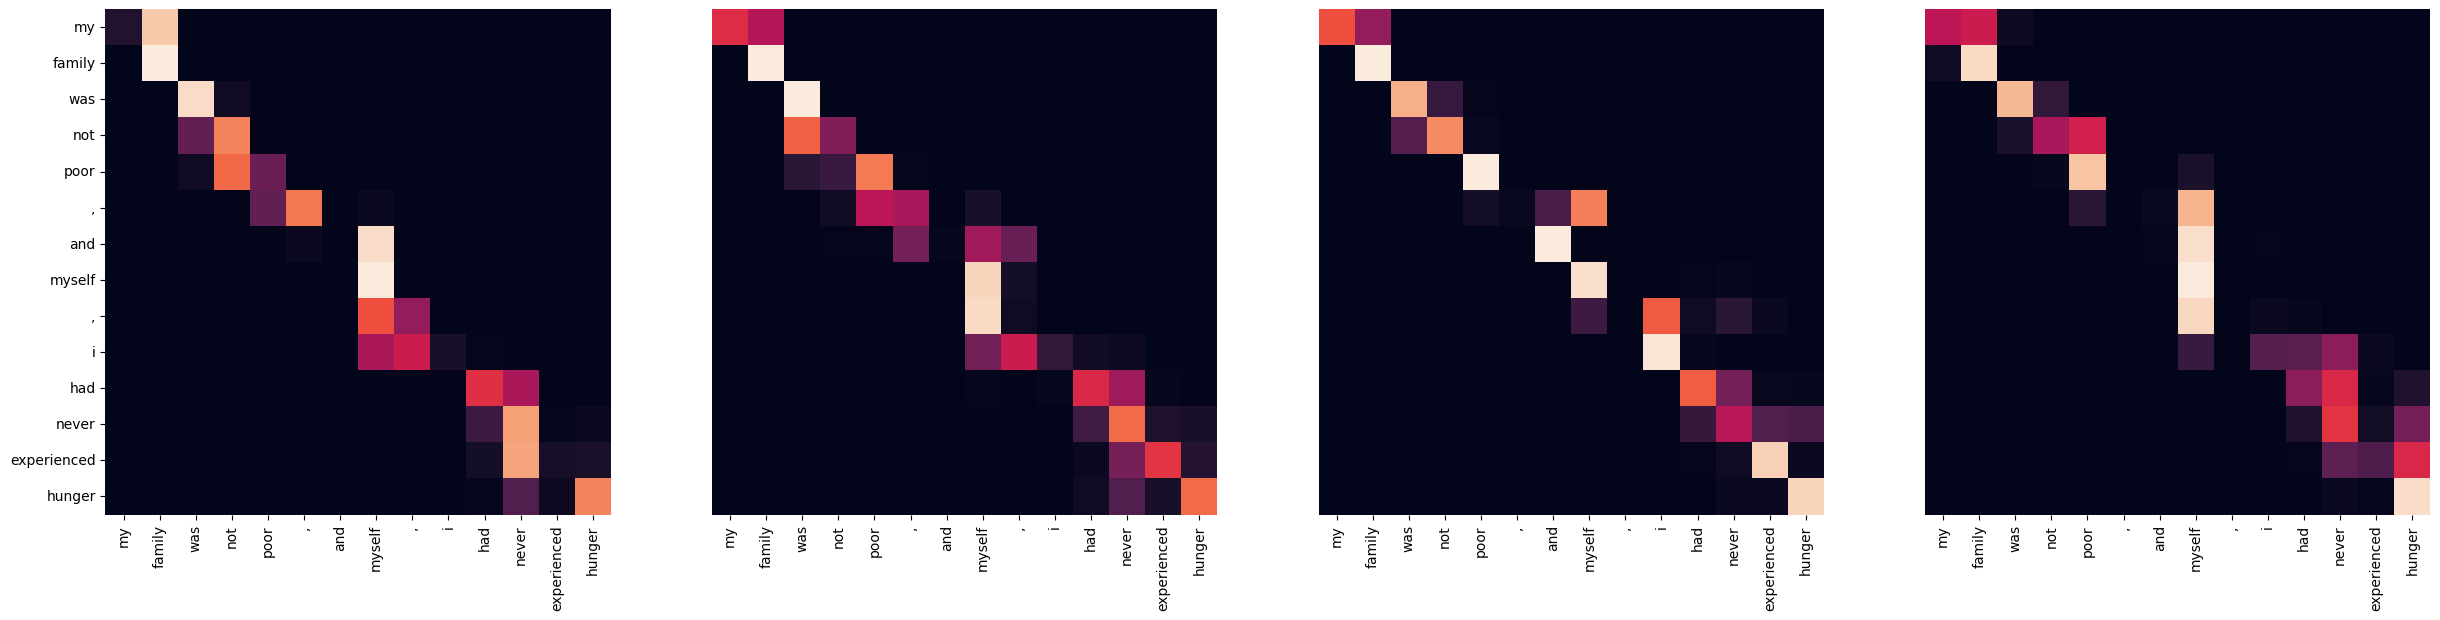

Encoder Layer 4


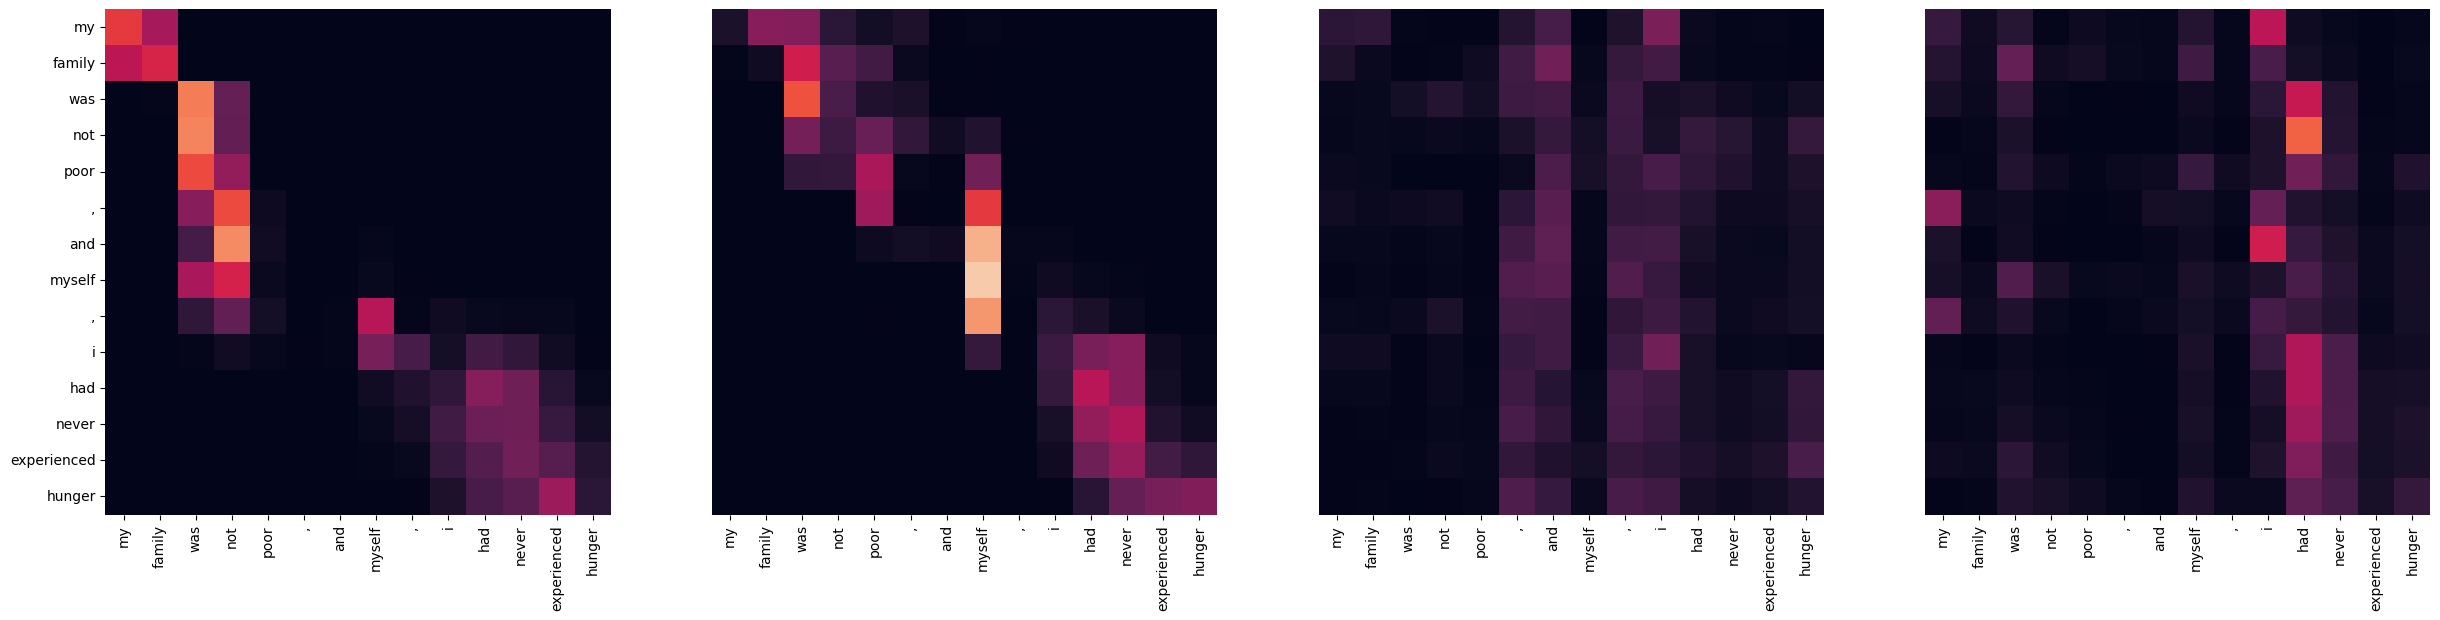

Encoder Layer 6


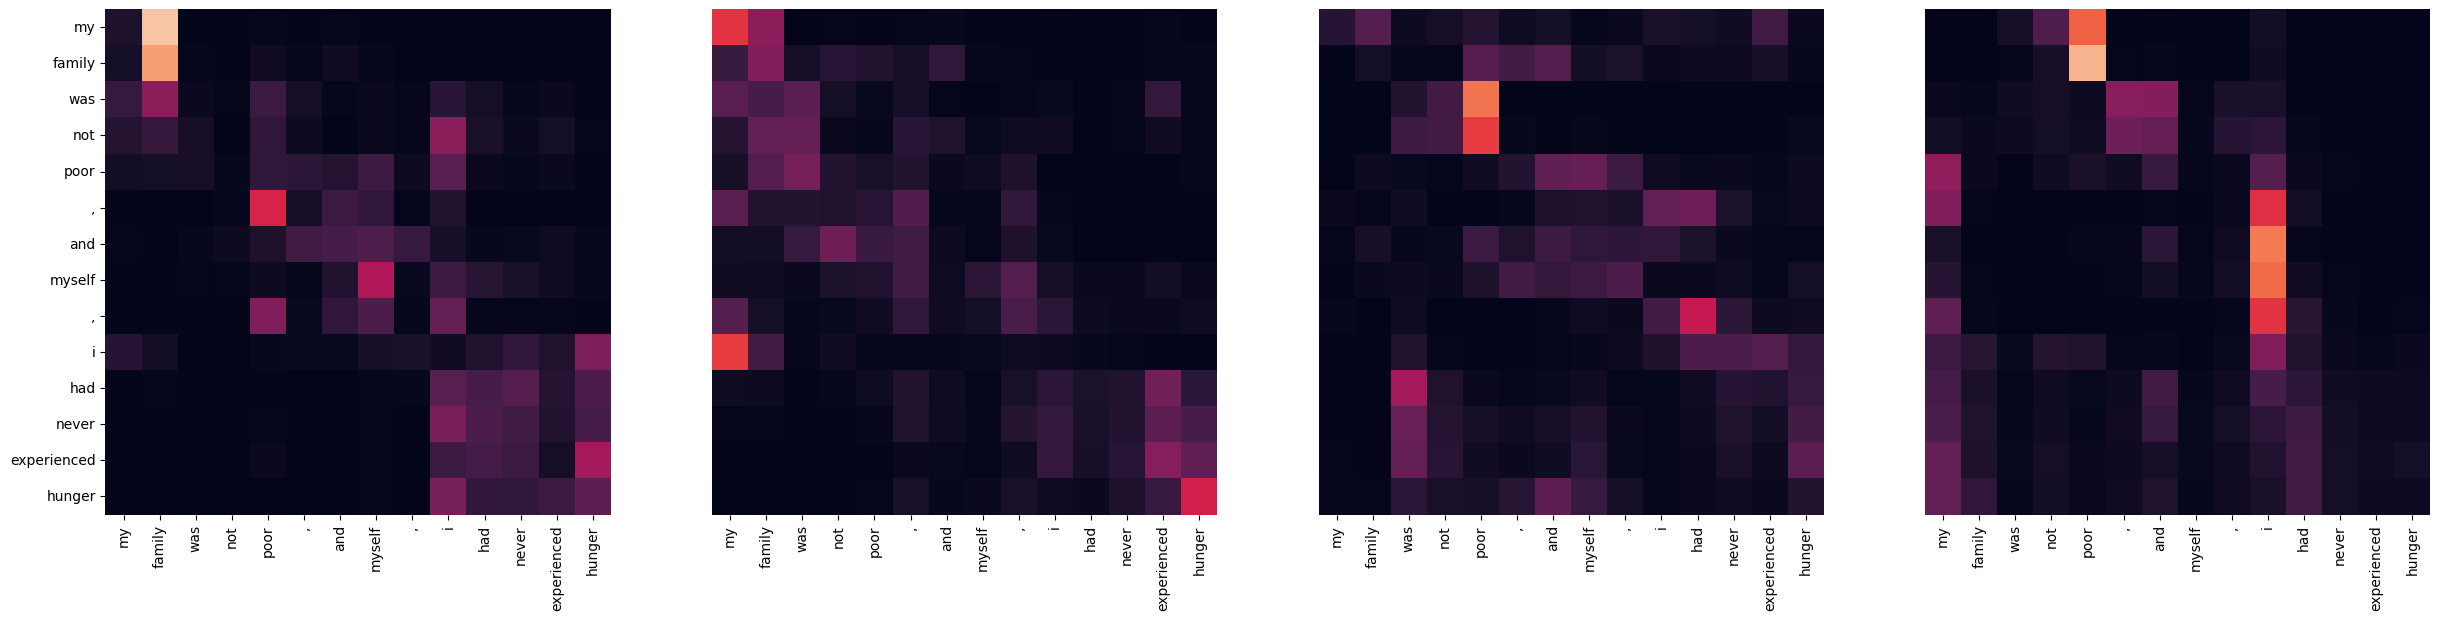

In [ ]:
sent = SRC1.preprocess(sentence)

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(30, 15))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model1.encoder.layers[layer].attn.attn[0, h].data.cpu(),
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()

#Giao diện

In [ ]:
!pip install gradio

In [ ]:
def translate_en_vi(sent):
  result = translate_sentence(sent, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'])
  result = result.replace("_"," ")
  return result
def translate_vi_en(sent):
  result = translate_sentence(sent, model1, SRC1, TRG1, opt['device'], opt['k'], opt['max_strlen'])
  return result

In [ ]:
import gradio as gr

option = ["Dịch Anh-Việt","Dịch Việt-Anh"]

def select_option(option,text):
  if option == "Dịch Anh-Việt":
    return translate_en_vi(text).replace("_"," ")
  else:
    return translate_vi_en(text)

select = gr.inputs.Dropdown(choices=option, label="Select an option")

text_input = gr.inputs.Textbox(label="Enter text")

interface = gr.Interface(fn=select_option, inputs=[select, text_input], outputs="text")

interface.launch()


<ipython-input-48-e7a77cce6ed7>:11: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  select = gr.inputs.Dropdown(choices=option, label="Select an option")
<ipython-input-48-e7a77cce6ed7>:11: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  select = gr.inputs.Dropdown(choices=option, label="Select an option")
<ipython-input-48-e7a77cce6ed7>:13: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  text_input = gr.inputs.Textbox(label="Enter text")
<ipython-input-48-e7a77cce6ed7>:13: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  text_input = gr.inputs.Textbox(label="Enter text")
<ipython-input-48-e7a77cce6ed7>:13: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  text_i

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>